In [4]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from scipy.ndimage import gaussian_filter1d
import imageio
from IPython.display import HTML
import pytoolsAL as ptAL
mpl.rcParams['pdf.fonttype'] = 42

import sys
sys.path.append("C:/Users/nadia/Documents/GitHub/steinmetzlab/wf + opto/figure-making")
from wfOpto import *

In [5]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [6]:
data = wfOpto(Path(r'Y:\Subjects\AL_0033\2025-01-28\1'))

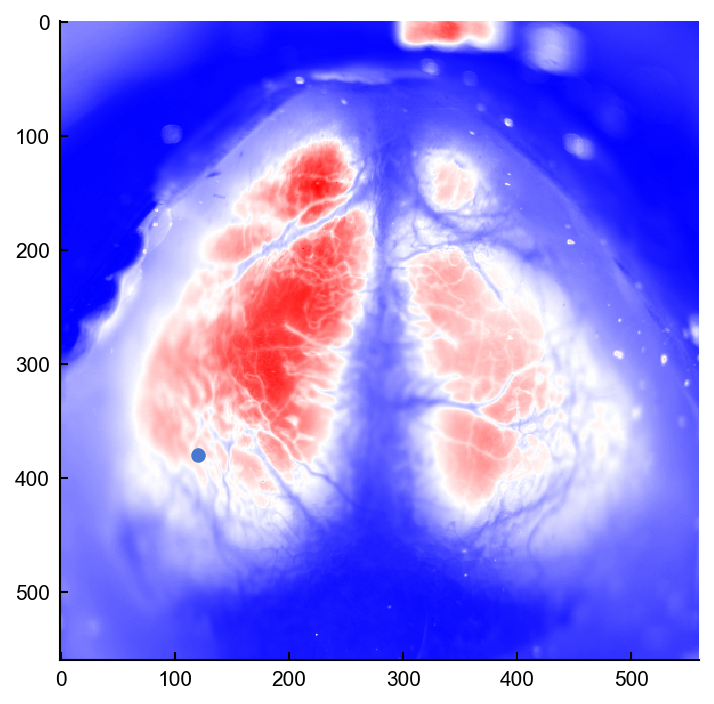

In [7]:
plt.imshow(data.meanImage, cmap='bwr')
plt.scatter(x=120,y=380)

In [8]:
name='AL33'
date='01-28'

([], [])

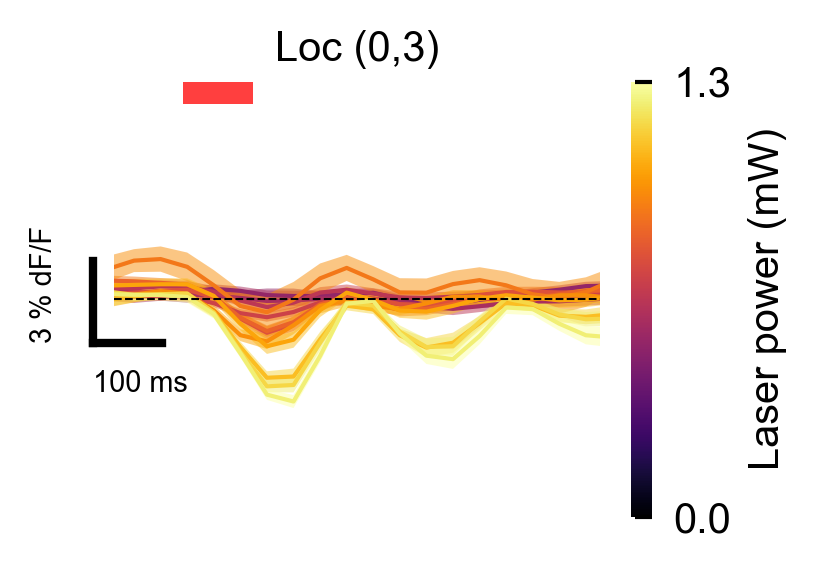

In [9]:
data=data
powers=np.unique(data.laserPowers).ravel()
galvoX=0;galvoY=3;x=120;y=400;width=15;anchor=(1,1)
ylim=[-0.008,0.001];start=-0.3;end=1;xlim=[-0.01,0.5]
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,13))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

meanimg = data.meanImage.reshape(560,560,-1)
avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

for power in powers:
    pwTrs = np.argwhere(data.laserPowers== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs[:45]:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = videoROI_avg/avg
        trial_activity.append(dff)
    sems.append(scipy.stats.sem(trial_activity,axis=0))
    pxPowers.append(np.mean(trial_activity,axis=0))


fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]

ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers[1:])]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1.3) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1.3])
cbar.outline.set_visible(False)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.03 # length of dff bar
x_start = 0 - 0.13 # where the bar should start
y_start = -0.016 # where the bar should start

plt.ylim([-.08,0.08])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
plt.title(f'Loc ({galvoX},{galvoY})')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

In [10]:
fig.savefig(f'opto/{name}_{date}_pi.png',dpi=300)